In [38]:
import numpy as np
import math
# Module to display T/F matrix
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
# Module for Unit testing
import pytest
# Module for convolutionnal decoder
import sk_dsp_comm.fec_conv as fec


In [39]:
my_data = np.genfromtxt('./tfMatrix.csv', delimiter=';')
mat_complex = my_data[:,0::2] +1j*my_data[:,1::2]
print(len(mat_complex))

14


#1

 la taille de la matrice est 14 car FFT a comme taille  1024 et 14 symbole par frame. 

  On doit récupérer juste la partie qui nous concerne à savoir les 624. les 312 premieres et la 2ème partie sera les 312 autres. le reste sera généralement du bruit ou idéalement des 0 dans notre cas. Il faut aussi sougliner qu'à la fréquence 0, on pas de signal 


In [40]:
 #-- Getting allocated subcarriers
tfMatrix_short = np.zeros((14, 624),dtype=np.complex128)
for i in range(0,13): 
    tfMatrix_short[i] = np.append(mat_complex[i][1:313], mat_complex[i][712:1024])
# print(tfMatrix_short)

/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: ComplexWarning: Casting complex values to real discards the imaginary part
  self.zmin = float(z.min())
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: ComplexWarning: Casting complex values to real discards the imaginary part
  _data = np.array(data, dtype=dtype, copy=copy,


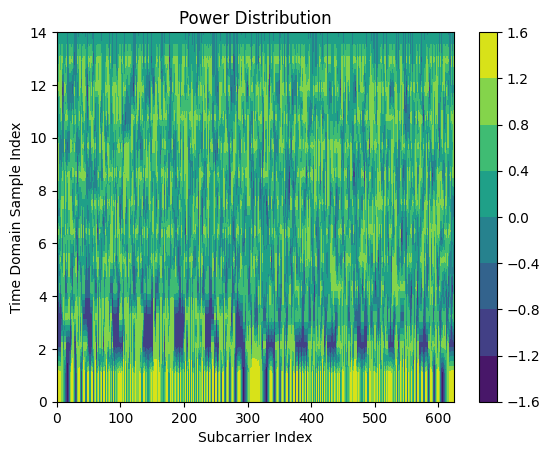

In [41]:
def powerDistributionGraph(Z):
    # Draw the power distribution graph
    fig, ax = plt.subplots()
    cs = ax.contourf(np.linspace(0, len(Z[0]), len(Z[0])), np.linspace(0, len(Z), len(Z)), Z)
    cbar = fig.colorbar(cs)
    ax.set_title('Power Distribution')
    ax.set_xlabel('Subcarrier Index')
    ax.set_ylabel('Time Domain Sample Index')

powerDistributionGraph(tfMatrix_short)


In [42]:
# --- Removing PSCH and SSCH channels
qamMatrix = tfMatrix_short[2:, :]

#print(len(qamMatrix[0]))

In [43]:
#2.2.1
pbch_symbols = qamMatrix[0,0:48]  #pour pbch on a 48 bit dans la OFFDM 3 (voir la figure dans le sujet) mais apres FEC il reste que 24 

#print(pbch_symbols) #c'est bien du 2-QAM car le resultat est que des 1 et des -1.

In [44]:
def bpsk_demod(qamSeq):
    bitSeq = []
    for qam in qamSeq:
        if qam.real > 0:
            bitSeq.append(1)
        else:
            bitSeq.append(0)
    return bitSeq

In [45]:
def test_bpsk():
    # BPSK decoding test
    assert bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0])) == [1, 1, 1, 0]
    assert bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0])) == [1, 1, 0, 1, 1, 1, 0, 1]
    assert bpsk_demod(np.array([1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0])) == [1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]
    assert bpsk_demod(np.array([-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0,-1.0+1j*0.0])) == [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]
    assert bpsk_demod(np.array([-1.2+1j*-0.2,-0.9+1j*-0.3,-1.1+1j*0.1,-1.0+1j*-0.0,-0.8+1j*0.2,-1.1+1j*-0.0,1.0+1j*0.2,-1.0+1j*0.0,-1.0+1j*0.1,1.2+1j*0.1,1.1+1j*-0.1,-1.0+1j*-0.1,1.1+1j*-0.1,-1.0+1j*0.2,-0.8+1j*-0.1,-1.0+1j*0.1])) == [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0]


In [46]:
test_bpsk()

In [47]:
print(bpsk_demod(pbch_symbols))

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1]


In [48]:
def hamming748_decode_word(bitSeq) :
    H=np.array([[0,0,0,1,1,1,1], [0,1,1,0,0,1,1], [1,0,1,0,1,0,1]])
    word=np.array([bitSeq[0],bitSeq[1],bitSeq[2],bitSeq[3],bitSeq[4],bitSeq[5],bitSeq[6]])
    e = np.dot(H,word)%2
    e_decimal= e[0]*2**2+e[1]*2**1+e[2]*2**0
    if e_decimal!=0:
        if sum(word)%2==bitSeq[-1]:
            return []
        else:
            bitSeq[e_decimal-1]=1-bitSeq[e_decimal-1]
    return bitSeq[0:4]

In [49]:
def hamming748_decode(bitSeq) :
    decoded = []
    for i in range(0,len(bitSeq),8):
        decoded += hamming748_decode_word(bitSeq[i:i+8])
    return decoded

In [50]:
def test_hammingDecode():
    # Decoding when no errors leads to sequence recovering
    assert hamming748_decode([1, 1, 0, 1, 0, 0, 1, 0]) == [1, 1, 0, 1] 
    assert hamming748_decode([1, 1, 0, 0, 1, 1, 0, 0]) == [1, 1, 0, 0]
    assert hamming748_decode([1, 1, 1, 1, 1, 1, 1, 1]) == [1, 1, 1, 1]
    assert hamming748_decode([0, 1, 1, 1, 1, 0, 0, 0]) == [0, 1, 1, 1]
    assert hamming748_decode([0, 1, 1, 0, 0, 1, 1, 0]) == [0, 1, 1, 0]
    assert hamming748_decode([0, 0, 1, 1, 0, 0, 1, 1]) == [0, 0, 1, 1]
    assert hamming748_decode([0, 0, 1, 0, 1, 1, 0, 1]) == [0, 0, 1, 0]
    assert hamming748_decode([0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1]) == [0, 0, 1, 1, 0, 0, 1, 0]
    # Ensure that one error is detected, and corrected
    assert hamming748_decode([1, 1, 0, 1, 0, 0, 0, 0]) == [1, 1, 0, 1]
    assert hamming748_decode([1, 1, 0, 0, 1, 1, 0, 0]) == [1, 1, 0, 0]
    assert hamming748_decode([1, 0, 1, 1, 1, 1, 1, 1]) == [1, 1, 1, 1]
    assert hamming748_decode([0, 1, 1, 1, 1, 0, 0, 0]) == [0, 1, 1, 1]
    assert hamming748_decode([0, 1, 1, 0, 0, 1, 1, 0]) == [0, 1, 1, 0]
    assert hamming748_decode([0, 0, 1, 1, 0, 0, 1, 0]) == [0, 0, 1, 1]
    assert hamming748_decode([0, 0, 1, 0, 1, 1, 0, 1]) == [0, 0, 1, 0]    
    # Ensure that two errors cannot be corrected
    assert hamming748_decode([1, 0, 1, 1, 0, 0, 1, 0]) != [1, 1, 0, 1]
    assert hamming748_decode([1, 1, 1, 1, 1, 1, 0, 0]) != [1, 1, 0, 0]
    assert hamming748_decode([0, 1, 1, 0, 1, 1, 1, 1]) != [1, 1, 1, 1]
    assert hamming748_decode([1, 0, 1, 1, 1, 0, 0, 0]) != [0, 1, 1, 1]
    assert hamming748_decode([1, 1, 1, 1, 0, 1, 1, 0]) != [0, 1, 1, 0]
    assert hamming748_decode([0, 1, 0, 1, 0, 0, 1, 1]) != [0, 0, 1, 1]
    assert hamming748_decode([0, 1, 0, 0, 1, 1, 0, 1]) != [0, 0, 1, 0]


In [51]:
test_hammingDecode()

In [52]:
def bin2dec(nb):
#Transform a binary list to an integer
    n = "0b"
    for b in nb:
        n = n + str(b)
    return int(n, 2)

In [53]:
def decode_PBCH(qamMatrix) :
    PBCHSeq=hamming748_decode(bpsk_demod(qamMatrix[0,0:64]))
    PBCHDict={}
    PBCHDict['cellIdent']=bin2dec(PBCHSeq[0:18])
    PBCHDict['NbUsers']=bin2dec(PBCHSeq[18:24])
    ident=bin2dec(PBCHSeq[24:32])
    i=48
    while ident != 10 and i<624 :
        i+=48
        PBCHSeq=hamming748_decode(bpsk_demod(qamMatrix[0,i:i+16]))
        ident=bin2dec(PBCHSeq[0:0+8])
    PBCHSeq=hamming748_decode(bpsk_demod(qamMatrix[0,i:i+48]))
    PBCHDict['ident']=bin2dec(PBCHSeq[0:8])
    PBCHDict['MCS']=bin2dec(PBCHSeq[8:10])
    PBCHDict['SymbStart']=bin2dec(PBCHSeq[10:14])
    PBCHDict['RBStart']=bin2dec(PBCHSeq[14:20])
    PBCHDict['HARQ']=bin2dec(PBCHSeq[20:24])
    return PBCHDict


In [54]:
print(decode_PBCH(qamMatrix))

{'cellIdent': 12345, 'NbUsers': 18, 'ident': 10, 'MCS': 2, 'SymbStart': 4, 'RBStart': 49, 'HARQ': 0}


In [55]:
def qpsk_demod(qamSeq):
    bitSeq = []
    for qam in qamSeq:            
        if qam.real > 0 and qam.imag > 0:
            bitSeq.append(1)
            bitSeq.append(1)
        elif qam.real > 0 and qam.imag < 0:
            bitSeq.append(1)
            bitSeq.append(0)
        elif qam.real < 0 and qam.imag > 0:
            bitSeq.append(0)
            bitSeq.append(1)
        elif qam.real < 0 and qam.imag < 0:
            bitSeq.append(0)
            bitSeq.append(0)
    return bitSeq

In [56]:
def test_qpsk():
    # QPSK decoding test
    assert qpsk_demod(np.array([-0.7+1j*-0.7,0.7+1j*-0.7])) == [0, 0, 1, 0]
    assert qpsk_demod(np.array([-0.7+1j*0.7,0.7+1j*-0.7,0.7+1j*-0.7,0.7+1j*0.7])) == [0, 1, 1, 0, 1, 0, 1, 1]
    assert qpsk_demod(np.array([-0.7+1j*0.7,0.7+1j*-0.7,0.7+1j*-0.7,-0.7+1j*-0.7,-0.7+1j*0.7,0.7+1j*-0.7,-0.7+1j*-0.7,-0.7+1j*0.7])) == [0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]
    assert qpsk_demod(np.array([-0.7+1j*0.7,-0.7+1j*-0.7,0.7+1j*-0.7,0.7+1j*0.7,-0.7+1j*0.7,0.7+1j*0.7,-0.7+1j*0.7,0.7+1j*-0.7])) == [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]
    assert qpsk_demod(np.array([-0.9+1j*0.6,-0.5+1j*-0.7,0.7+1j*-0.6,0.7+1j*0.9,-0.8+1j*0.6,0.8+1j*0.7,-0.6+1j*0.6,0.7+1j*-0.7])) == [0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0]

In [57]:
test_qpsk()

In [58]:
def demod(flag_MCS, qamSeq):
    if flag_MCS == 0:
        return bpsk_demod(qamSeq)
    elif flag_MCS == 2 :
        return qpsk_demod(qamSeq)

In [59]:
def decode_PDCCHU(qamMatrix, PBCHDico):
    RBStart=PBCHDico['RBStart']-1
    SymbStart=PBCHDico['SymbStart']-2 -1
    PCDDHUSeq=hamming748_decode(demod(PBCHDico['MCS'],qamMatrix.flatten()[624*SymbStart+RBStart*12:624*SymbStart+RBStart*12+72]))
    PDCCHUDict={}
    PDCCHUDict['UserIdent']=bin2dec(PCDDHUSeq[0:8])
    if (PBCHDico['ident']!=PDCCHUDict['UserIdent']):
        print(PDCCHUDict['UserIdent'])
        print("Error : PDCCHU not found")
        return
    PDCCHUDict['MCS']=bin2dec(PCDDHUSeq[8:14])
    PDCCHUDict['SymbStart']=bin2dec(PCDDHUSeq[14:18])
    PDCCHUDict['RBStart']=bin2dec(PCDDHUSeq[18:24])
    PDCCHUDict['RBSize']=bin2dec(PCDDHUSeq[24:34])
    PDCCHUDict['CRC']=bin2dec(PCDDHUSeq[34:36])
    return PDCCHUDict

In [60]:
print(decode_PDCCHU(qamMatrix, decode_PBCH(qamMatrix)))

{'UserIdent': 10, 'MCS': 7, 'SymbStart': 9, 'RBStart': 35, 'RBSize': 27, 'CRC': 0}


In [61]:
def qam16_demod(input_sequence):
    # %FIXME Scaling vector 
    input_sequence = input_sequence * math.sqrt(2/3*(16-1))
    # Need to switch to vector 
    input_sequence = np.matrix.flatten(input_sequence)
    # Instantiate an empty list
    output_sequence = []
    # Decoding each element 
    for elem in input_sequence:
        # --- Real part decision 
        if np.real(elem) < -  2:
            bit1 = 1
            bit3 = 0
        elif  np.real(elem) < 0:
            bit1 = 1
            bit3 = 1
        elif  np.real(elem) < 2:
            bit1 = 0
            bit3 = 1
        else:
            bit1 = 0
            bit3 = 0

        # Imag part 
        if np.imag(elem) < -2:
            bit2 = 1
            bit4 = 0
        elif  np.imag(elem) < 0:
            bit2 = 1
            bit4 = 1
        elif  np.imag(elem) < 2:
            bit2 = 0
            bit4 = 1
        else:
            bit2 = 0
            bit4 = 0
        output_sequence.append(bit1)
        output_sequence.append(bit2)
        output_sequence.append(bit3)
        output_sequence.append(bit4)
    return output_sequence


In [62]:
def test_qam16():
    # QAM-16 decoding test
    assert qam16_demod(np.array([-0.9+1j*0.3])) == [1, 0, 0, 1]
    assert qam16_demod(np.array([-0.3+1j*-0.9,-0.3+1j*0.9])) == [1, 1, 1, 0, 1, 0, 1, 0]
    assert qam16_demod(np.array([-0.9+1j*-0.9,-0.3+1j*0.3,-0.3+1j*0.9,-0.9+1j*-0.3])) == [1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1]
    assert qam16_demod(np.array([0.9+1j*-0.9,-0.3+1j*0.9,0.9+1j*-0.9,-0.3+1j*-0.9])) == [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0]
    assert qam16_demod(np.array([1.1+1j*-0.8,-0.2+1j*0.8,1.2+1j*-0.9,-0.1+1j*-0.8])) == [0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0]


In [63]:
test_qam16()

In [64]:
def PBCHU_demod(qamSeq,mcs):
    if mcs%5==0:
        return bpsk_demod(qamSeq)
    elif mcs%5==1:
        return qpsk_demod(qamSeq)
    elif mcs%5==2:
        return qam16_demod(qamSeq)

In [65]:
def PBCHU_fec(qamSeq, mcs):
    if mcs<20 :
        cc1 = fec.FECConv(('1011011','1111001'),6)
        dec = cc1.viterbi_decoder(np.array(qamSeq).astype(int),'hard')                
        return dec
    else:
        return hamming748_decode(qamSeq)

In [66]:
""" Check the CRC polynom. Returns 1 if the CRC is correct and 0 otherwise """
def crc_decode(data,poly):
    data2 = np.copy(data)       # Copy of working vector 
    lenR  = len(data);           # length of the received codeword
    lenGW = len(poly);          # length of the generator
    for i in range(lenR - lenGW + 1):
        if data2[i] == 1:
            data2[i:i+lenGW:1] = np.logical_xor(data2[i:i+lenGW:1],poly);
	# syndrome is now equal to the remainder of xor division
    syndrome = data2[ lenR - lenGW + 1: lenR : 1];
    #print(syndrome)
    if all(syndrome == 0x00):
        err = 1
    else: 
        err = 0;
    print(err)
    return err


""" Create the CRC polynom of size crcSize, based on the positions of the 1 in the CRC polynoms """
def create_g(crcSize,positions):
    gx = np.zeros(1+crcSize)
    gx[0] = 1
    for k in positions:
        gx[k] = 1
    return gx 

""" Returns the generated CRC polynoms for the given size """
def get_crc_poly(crcSize):
    if crcSize == 8:
        gx = create_g(crcSize,[1,2,8])
    elif crcSize == 16:
        gx = create_g(crcSize,[2,15,16])
    elif crcSize == 24:
        gx = create_g(crcSize,[1,3,6,7,8,10,11,13,14,16,18,19,20,22,24])
    elif crcSize == 32:
        gx = create_g(crcSize,[1,2,4,5,7,8,10,11,12,16,22,23,26,32])
    return gx


def test_crcGen():
    gx = get_crc_poly(8)
    assert len(gx) == 9 
    assert gx[0] == 1 
    assert sum(gx) == 4

def test_crcDecode():
    sizeCRC = 8
    gx = get_crc_poly(sizeCRC)
    seq = np.array([0,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1])
    crc = crc_decode(seq,gx)
    assert crc == 1
    seq = np.array([1,1,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,1])
    crc = crc_decode(seq,gx)
    assert crc == 0

test_crcGen()
test_crcDecode()

1
0


In [67]:
def PBCHU_crc(qamSeq, crc):
    crcSize= 8+8*crc
    gx = get_crc_poly(crcSize)
    return crc_decode(qamSeq,gx)


In [68]:
#Apply the Cesar transformation to the ASCII input to perform (trivial) decoding 
 
def cesarDecode(userIdent,messEnc): 
    cesarKey = getCesarKey(userIdent)
    mess = []
    for elem in messEnc:
        rr = (elem - cesarKey)%(0xFF)
        mess.append(rr)
    return mess 


#Convert a binary array into a Byte arrays 

def bitToByte(array):
    mess = []
    nbWord = math.floor(len(array) / 8)
    for n in range(nbWord):
        w = 0
        for k in range(8):
            w += array[ n * 8 + k ] * 2**k
        mess.append(w)
    return mess 

#Convert a byte array into a comprehensive string
def toASCII(mess):
    word = []
    for x in mess:
        word.append(chr(int(x)))
    return word 


def getCesarKey(userId):
    # We have hard coded an interleaver between 1 and 26 and then we modulo 
	# Not using Cesar key system 
    cesarVect =   [5,
                   6,
                   10,
                   23,
                   18,
                   3,
                   9,
                   14,
                   2,
                   13,
                   8,
                   17,
                   0,
                   12,
                   4,
                   22,
                   11,
                   7,
                   20,
                   25,
                   15,
                   19,
                   24,
                   21,
                   1,
                   16];
    return cesarVect[(userId-1)%26] 

In [74]:
def PDSCHU_decode(qamMatrix, PDCCHUDict, UserGroup):
    RBStart=PDCCHUDict['RBStart']-1
    SymbStart=PDCCHUDict['SymbStart']-2 -1
    PDSCHUSeq=PBCHU_fec(PBCHU_demod(qamMatrix.flatten()[624*SymbStart+RBStart*12:624*SymbStart+RBStart*12+72],PDCCHUDict['MCS']),PDCCHUDict['MCS'])
    print(PDSCHUSeq, len(PDSCHUSeq))
    if PBCHU_crc(PDSCHUSeq,PDCCHUDict['CRC'])!=1:
        raise ValueError('CRC error')
    else:
        mess = bitToByte(PDSCHUSeq)
        # Bytes are "encrypted", uncrypt them
        real_mess = cesarDecode(UserGroup,mess); # USER is your user group
        final_mess = toASCII(real_mess)
        


In [75]:
PDSCHU_decode(qamMatrix, decode_PDCCHU(qamMatrix, decode_PBCH(qamMatrix)), 7)

[0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1.] 139
0


ValueError: CRC error